In [110]:
# """
# predicting a sequence of future prices (`n_steps_out`) instead of just one.

# Benefits of This Approach
# Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
# More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
# Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.
# """

time: 309 µs (started: 2024-11-24 11:19:44 +00:00)


In [111]:
# !pip install -r requirements.txt -q
# !pip install ipython-autotime -q
# # !pip install tensorflow-addons -q

time: 205 µs (started: 2024-11-24 11:19:44 +00:00)


In [112]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
tensorflow version: 2.15.0
Num GPUs Available:  1


True

time: 3.69 ms (started: 2024-11-24 11:19:44 +00:00)


In [113]:
# parameter
# n_steps_in: Number of input time steps
# n_steps_out: Number of days to predict ahead

n_steps_in = 14  
n_steps_out = 5
epochs = 200
batch_size = 64

time: 281 µs (started: 2024-11-24 11:19:44 +00:00)


In [114]:
def load_processed_data(data_dir='processed_data', df_name='', array_name=''):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / df_name, 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    with open(data_path / array_name, 'rb') as f:
        values_list = joblib.load(f)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data(df_name='processed_dfs.pkl', array_name='values_array.pkl')

time: 43.2 ms (started: 2024-11-24 11:19:44 +00:00)


In [115]:
for i in range(len(processed_dfs)):
    # processed_dfs[i].drop(processed_dfs[i].columns[1:5], axis=1, inplace=True)
    processed_dfs[i].drop(columns=['RSI', 'WR','Price Momentum', 'Volume Momentum', 'EMA7', 'CCI', 'Ulcer Index'],inplace=True)
processed_dfs[0]

/tmp/ipykernel_4718/3160250006.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  processed_dfs[i].drop(columns=['RSI', 'WR','Price Momentum', 'Volume Momentum', 'EMA7', 'CCI', 'Ulcer Index'],inplace=True)


Price,Adj Close,Close,High,Low,Open,Volume,SD20,SMA7,SMA14,SMA21,...,Lower Band,ARIMA Output,Fourier Power,Fourier Phase,Fourier 3 Real,Fourier 6 Real,Fourier 9 Real,Fourier 100 Real,Fourier Significant real,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2011-08-16,11.462601,13.588571,13.691786,13.430714,13.625714,1000000.0,0.441967,13.293316,13.563801,13.700425,...,12.850948,11.386598,564.736488,1.784183,50.608489,10.548855,-3.418024,12.356305,16.000357,13.587143
2011-08-17,11.461396,13.587143,13.732857,13.500000,13.653929,1000000.0,0.442083,13.432245,13.534770,13.706531,...,12.839185,11.624125,497.700387,1.823144,50.372918,10.291735,-3.410067,12.751208,15.711276,13.073214
2011-08-18,11.027875,13.073214,13.308929,12.906071,13.244286,1000000.0,0.462345,13.391633,13.472449,13.671071,...,12.761759,11.368409,645.802434,1.591148,50.137814,10.037805,-3.396865,13.168186,15.424764,12.715357
2011-08-19,10.726002,12.715357,13.107143,12.714286,12.934643,1000000.0,0.498631,13.352551,13.368571,13.617908,...,12.624472,11.025292,707.291371,1.742971,49.903177,9.787063,-3.378466,13.593889,15.140825,12.730000
2011-08-22,10.738355,12.730000,13.031429,12.681786,13.018214,1000000.0,0.510826,13.264490,13.285740,13.555221,...,12.525591,10.494964,569.391019,1.997446,49.669010,9.539509,-3.354922,14.014846,14.859461,13.342857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-24,230.316620,230.570007,230.820007,228.410004,229.979996,1000000.0,3.892879,233.228570,230.810000,229.767143,...,222.290882,230.674707,21857.804244,-1.509946,105.115706,115.104123,117.980892,188.509112,114.330593,231.410004
2024-10-25,231.155685,231.410004,233.220001,229.570007,229.740005,1000000.0,3.874728,233.175714,231.504286,229.952381,...,222.507266,231.297362,30163.314500,-1.569032,104.839212,114.481354,117.032685,177.737174,113.773702,233.399994


time: 30.6 ms (started: 2024-11-24 11:19:45 +00:00)


In [116]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Remove 'Close Next Day' from features (last column)
        features = scaled_values[:, :-1]  # All columns except the last one
        targets = scaled_values[:, -1]    # Only the last column
        
        # Split into train/validation
        n_train = int(len(features) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(features)} samples is too short for meaningful splitting")
            continue
            
        # Split features and targets
        train_features = features[:n_train]
        train_targets = targets[:n_train]
        val_features = features[n_train:]
        val_targets = targets[n_train:]
        
        # Create sequences
        if len(train_features) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(train_features, train_targets, n_steps_in, n_steps_out)
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_features) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(val_features, val_targets, n_steps_in, n_steps_out)
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    print(f"Number of features: {train_X.shape[2]}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(features, targets, n_steps_in, n_steps_out):
    """
    Generate synchronized sequences for LSTM input features and output targets.
    
    Args:
        features: Scaled feature data (numpy array)
        targets: Scaled target data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(features) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(features) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = features[i:(i + n_steps_in)]
        # Output sequence (next n_steps_out days of target variable)
        seq_y = targets[(i + n_steps_in):(i + n_steps_in + n_steps_out)]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(values_list, n_steps_in, n_steps_out, train_split=0.8)

Training shapes: X=(66115, 14, 32), y=(66115, 5)
Validation shapes: X=(16184, 14, 32), y=(16184, 5)
Number of features: 32
time: 242 ms (started: 2024-11-24 11:19:45 +00:00)


# training

In [117]:
# import tensorflow_addons as tfa

# Cyclical learning rate
# steps_per_epoch = len(train_X) // batch_size
# n = 2
# cycle = 12
# epochs = cycle * n * 2
# print(epochs)

# clr = tfa.optimizers.TriangularCyclicalLearningRate(
#     initial_learning_rate=1e-4,
#     maximal_learning_rate=1e-2,
#     step_size = n * steps_per_epoch)

def create_lstm_model(n_steps_in, n_features, n_steps_out):
    tf.keras.backend.clear_session()
    model = Sequential([
        LSTM(250, activation='leaky_relu', dropout=0.025, input_shape=(n_steps_in, n_features)),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(1e-4)
    loss = ['mae']
    model.compile(optimizer=optimizer, loss_weights=[1], loss=loss)
    model.summary()
    
    return model

# Create and train model
model = create_lstm_model(n_steps_in=n_steps_in, n_features=train_X.shape[2], n_steps_out=n_steps_out)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               283000    
                                                                 
 dense (Dense)               (None, 5)                 1255      
                                                                 
Total params: 284255 (1.08 MB)
Trainable params: 284255 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
time: 135 ms (started: 2024-11-24 11:19:45 +00:00)


In [118]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=epochs,
    batch_size=64,
    verbose=2,
    shuffle=False,
    callbacks=[early_stopping],
)

model.save('./model/lstm_model.keras')

Epoch 1/200
1034/1034 - 14s - loss: 0.0103 - val_loss: 0.0194 - 14s/epoch - 14ms/step
Epoch 2/200
1034/1034 - 12s - loss: 0.0057 - val_loss: 0.0139 - 12s/epoch - 12ms/step
Epoch 3/200
1034/1034 - 13s - loss: 0.0053 - val_loss: 0.0155 - 13s/epoch - 13ms/step
Epoch 4/200
1034/1034 - 13s - loss: 0.0050 - val_loss: 0.0135 - 13s/epoch - 12ms/step
Epoch 5/200
1034/1034 - 12s - loss: 0.0049 - val_loss: 0.0127 - 12s/epoch - 12ms/step
Epoch 6/200
1034/1034 - 12s - loss: 0.0045 - val_loss: 0.0122 - 12s/epoch - 12ms/step
Epoch 7/200
1034/1034 - 12s - loss: 0.0045 - val_loss: 0.0093 - 12s/epoch - 12ms/step
Epoch 8/200
1034/1034 - 12s - loss: 0.0043 - val_loss: 0.0090 - 12s/epoch - 12ms/step
Epoch 9/200
1034/1034 - 12s - loss: 0.0041 - val_loss: 0.0091 - 12s/epoch - 12ms/step
Epoch 10/200
1034/1034 - 13s - loss: 0.0041 - val_loss: 0.0086 - 13s/epoch - 12ms/step
Epoch 11/200
1034/1034 - 12s - loss: 0.0040 - val_loss: 0.0088 - 12s/epoch - 12ms/step
Epoch 12/200
1034/1034 - 12s - loss: 0.0040 - val_lo

In [119]:
model = tf.keras.models.load_model('./model/lstm_model.keras')

time: 154 ms (started: 2024-11-24 11:53:08 +00:00)


In [120]:
print(f"min val loss:", min(history.history['val_loss']) )
# Make predictions
y_pred = model.predict(val_X)
print(y_pred.shape)
# Evaluate for each time step
for i in range(n_steps_out):
    mae = mean_absolute_error(val_y[:, i], y_pred[:, i])
    print(f"MAE for step {i+1}: {mae: .4f}")

min val loss: 0.005480819381773472
506/506 [==============================] - 2s 3ms/step
(16184, 5)
MAE for step 1:  0.0041
MAE for step 2:  0.0047
MAE for step 3:  0.0054
MAE for step 4:  0.0066
MAE for step 5:  0.0066
time: 1.75 s (started: 2024-11-24 11:53:08 +00:00)


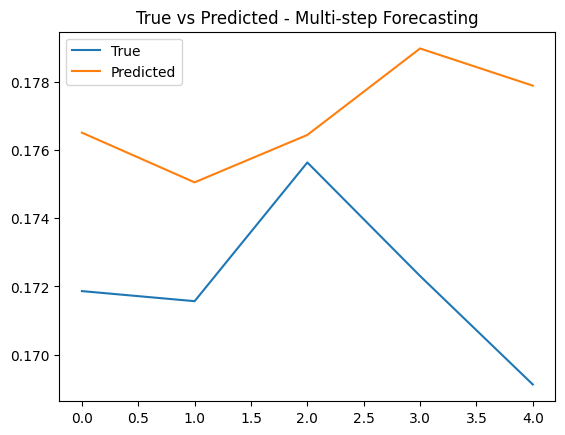

time: 272 ms (started: 2024-11-24 11:53:10 +00:00)


In [121]:
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()

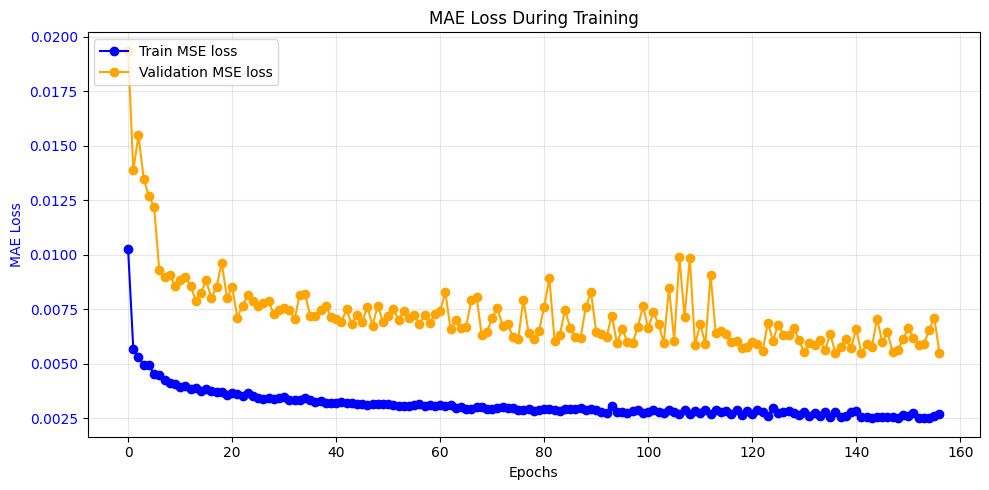

time: 359 ms (started: 2024-11-24 11:53:10 +00:00)


In [122]:
# Plotting
fig1, ax1 = plt.subplots(figsize=(10, 5))

# Loss plot
N = len(history.history["loss"])
epoch_range = np.arange(0, N)

ax1.plot(epoch_range, history.history["loss"], label='Train MSE loss', marker='o', color='blue')
ax1.plot(epoch_range, history.history["val_loss"], label='Validation MSE loss', marker='o', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
plt.grid(True, alpha=0.3)
ax1.set_title('MAE Loss During Training')

# RMSE plot (shared x-axis, different y-axis)
# ax2 = ax1.twinx()
# fig2, ax2 = plt.subplots(figsize=(10, 5))
# ax2.plot(epoch_range, history.history["unscaled_mse"], label='Train MSE', color='green')
# ax2.plot(epoch_range, history.history["val_unscaled_mse"], label='Validation MSE', color='red')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Root Mean Squared Error (RMSE)', color='green')
# ax2.tick_params(axis='y', labelcolor='green')
# ax2.legend(loc='upper left')
# plt.grid(True, alpha=0.3)
# ax2.set_title('RMSE During Training')

plt.tight_layout()
plt.show()


Analyzing AAPL...

Evaluation Metrics for AAPL:
MSE: 24.1797
RMSE: 4.9173
MAE: 3.8753


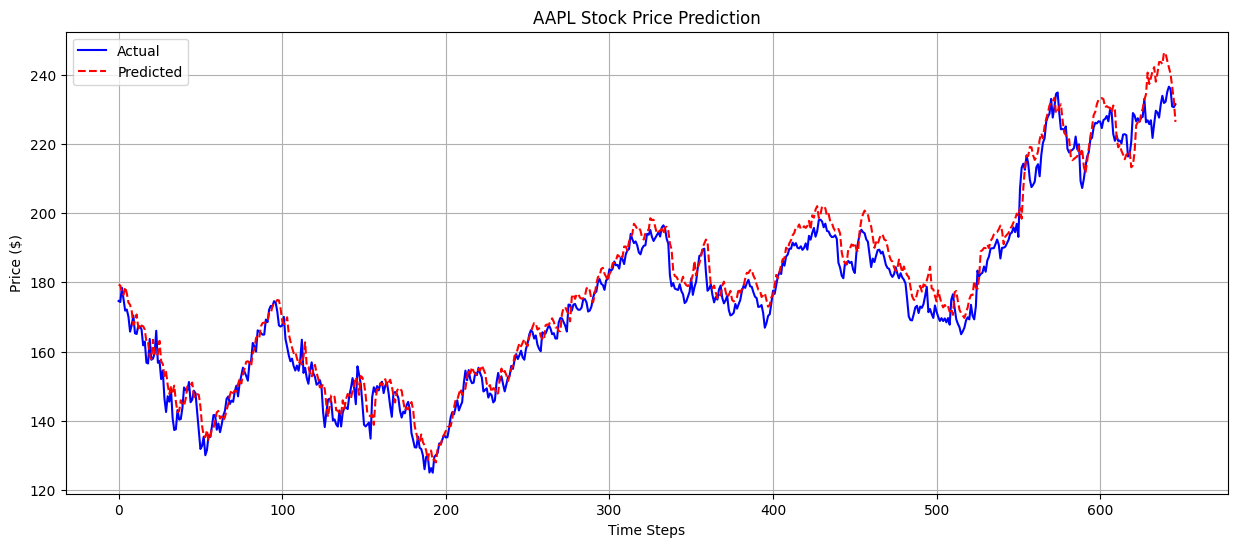


Analyzing AMZN...

Evaluation Metrics for AMZN:
MSE: 21.5506
RMSE: 4.6423
MAE: 3.6075


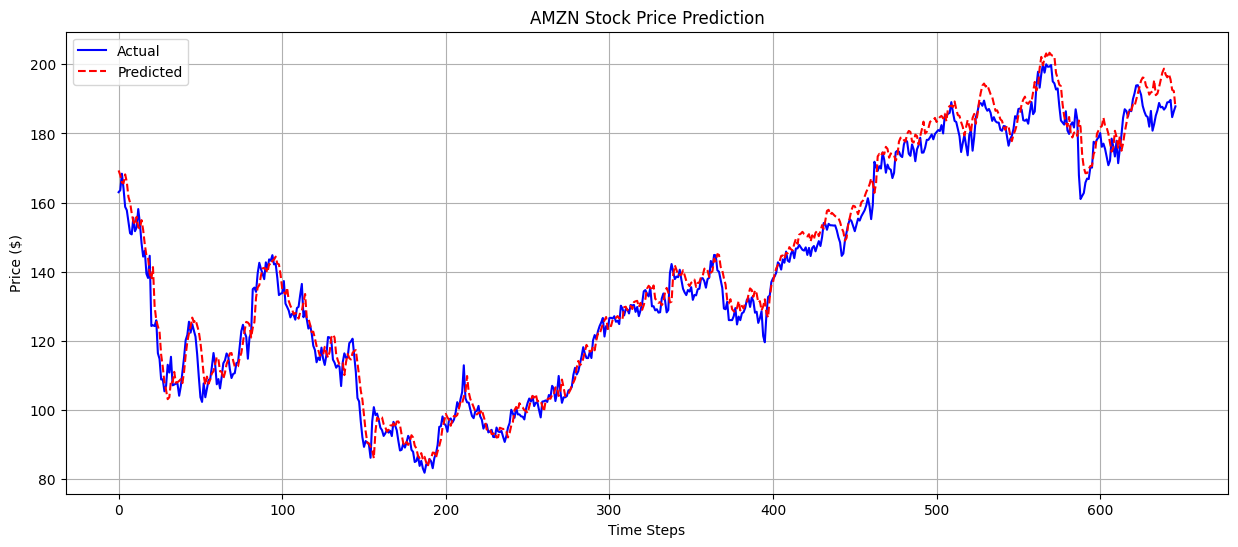


Analyzing GME...

Evaluation Metrics for GME:
MSE: 6.9829
RMSE: 2.6425
MAE: 1.6990


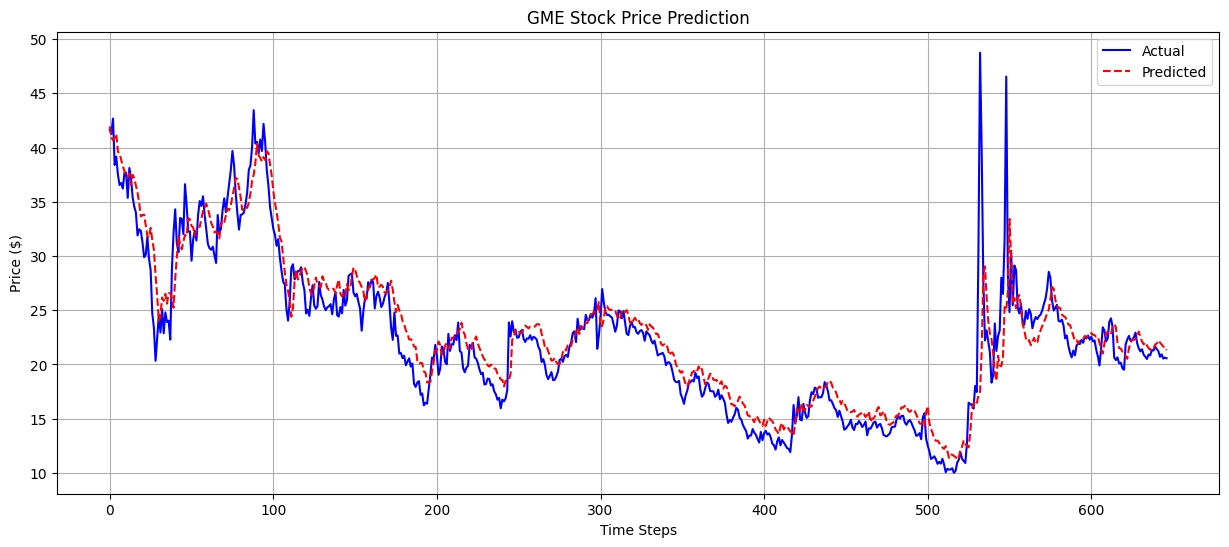


Analyzing GOOGL...

Evaluation Metrics for GOOGL:
MSE: 14.3369
RMSE: 3.7864
MAE: 2.9370


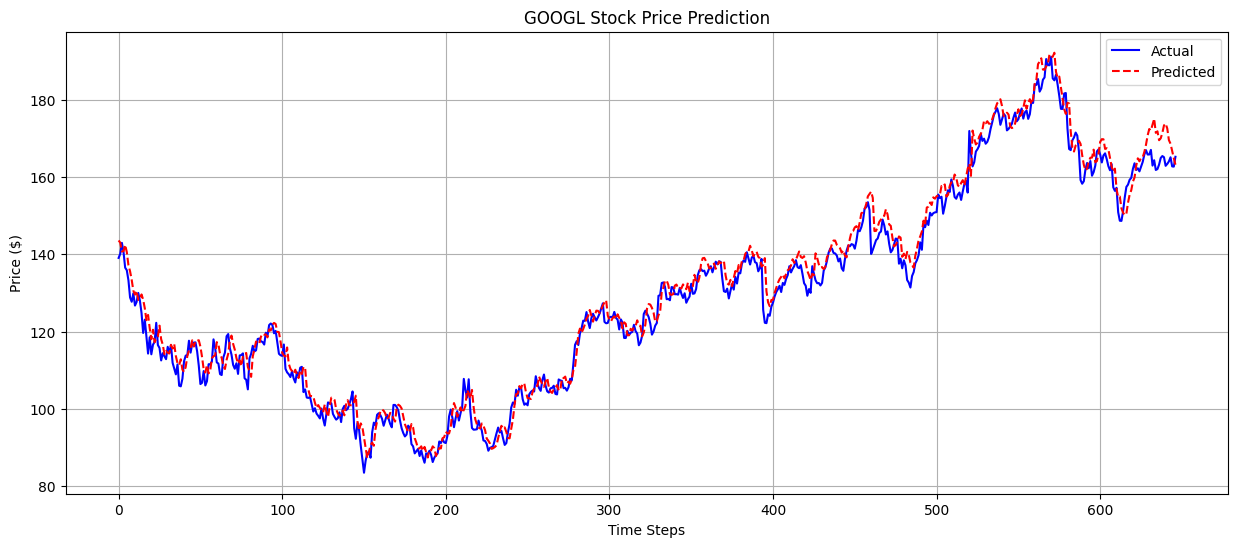


Analyzing NFLX...

Evaluation Metrics for NFLX:
MSE: 229.0555
RMSE: 15.1346
MAE: 10.7351


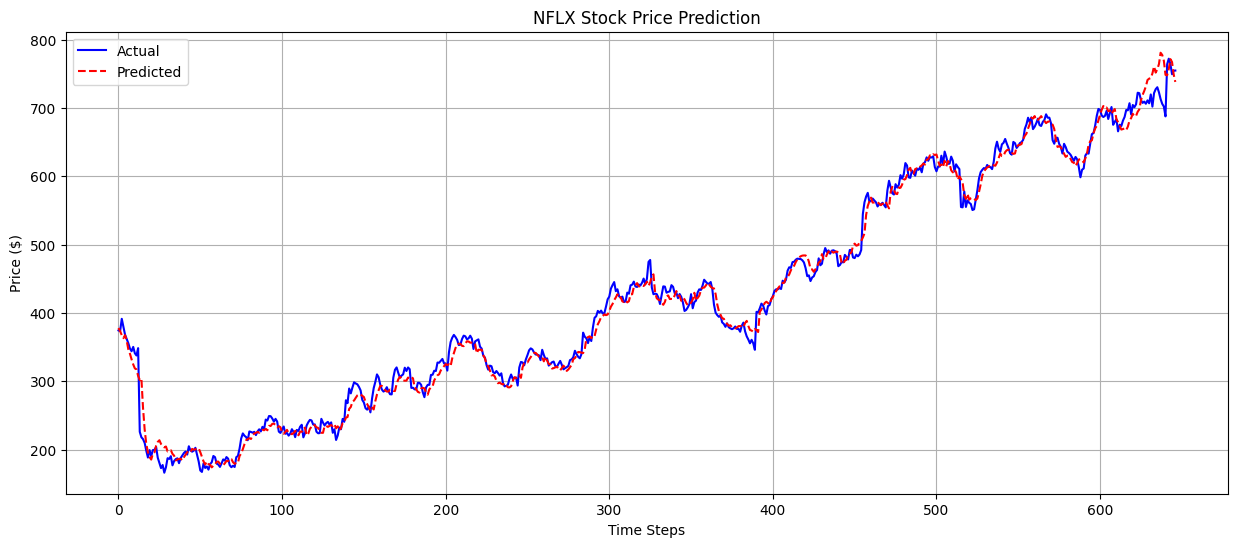


Analyzing TSLA...

Evaluation Metrics for TSLA:
MSE: 111.2078
RMSE: 10.5455
MAE: 8.1508


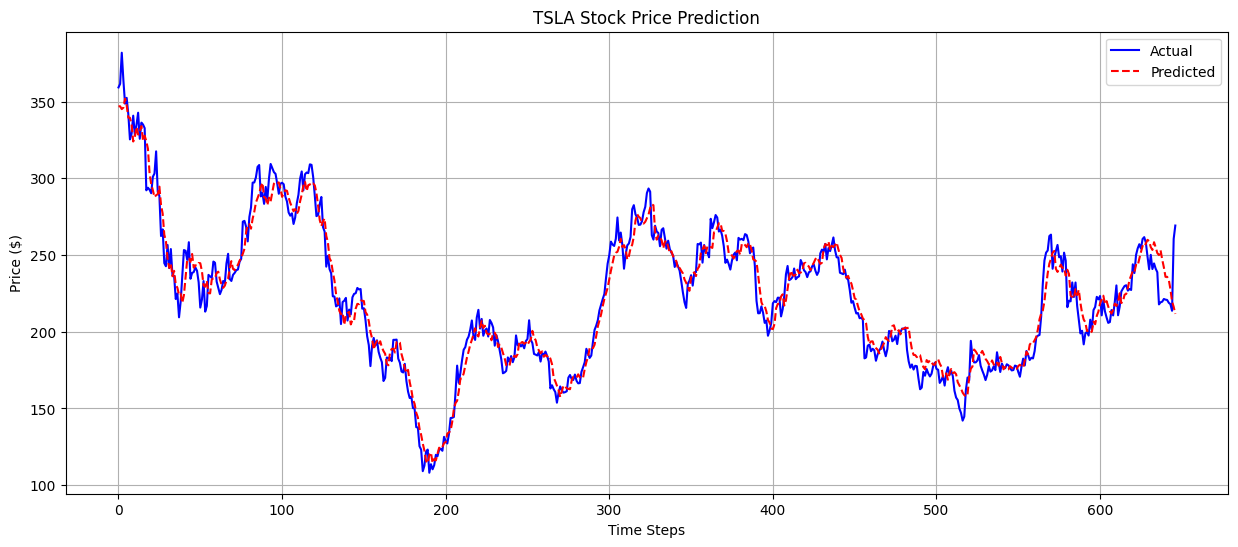


Analyzing MSFT...

Evaluation Metrics for MSFT:
MSE: 51.2023
RMSE: 7.1556
MAE: 5.5107


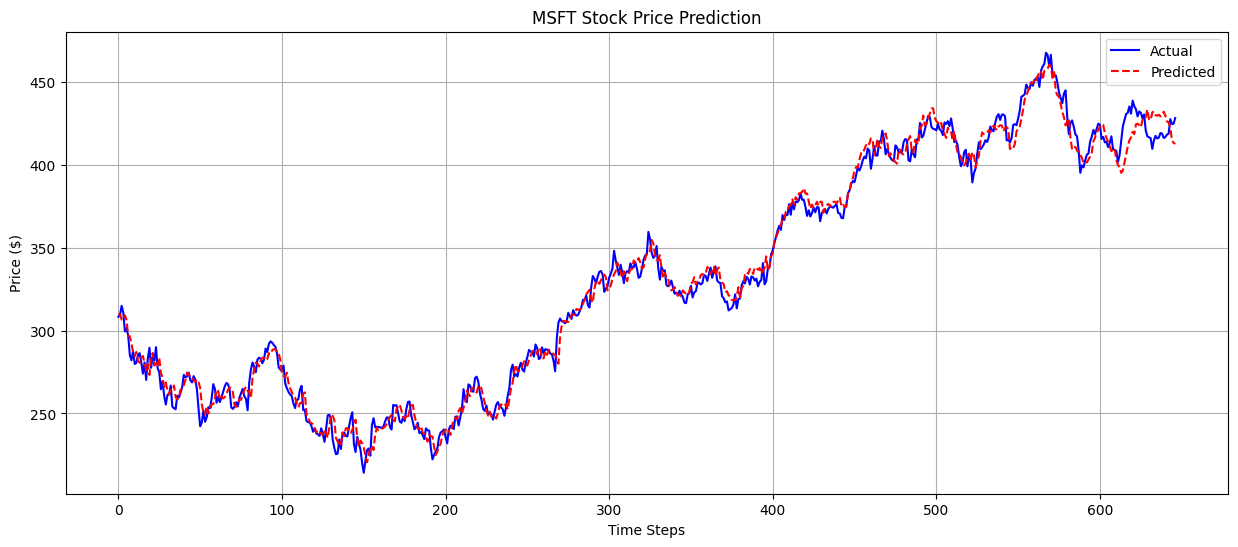


Analyzing NVDA...

Evaluation Metrics for NVDA:
MSE: 8.0978
RMSE: 2.8457
MAE: 1.9094


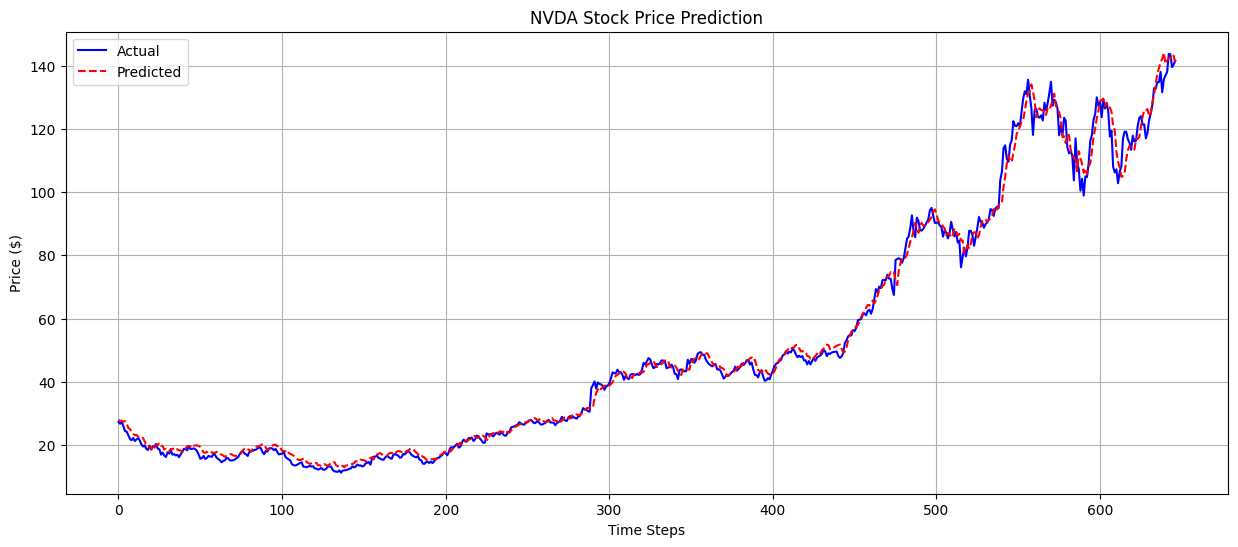


Analyzing AMD...

Evaluation Metrics for AMD:
MSE: 24.4986
RMSE: 4.9496
MAE: 3.7951


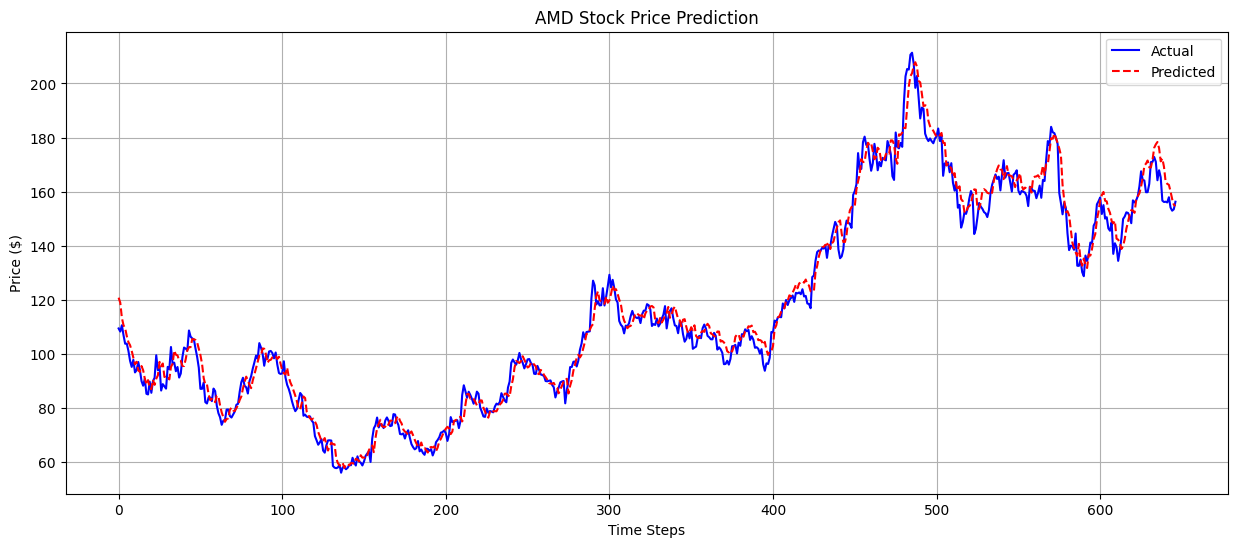


Analyzing CRM...

Evaluation Metrics for CRM:
MSE: 41.9933
RMSE: 6.4802
MAE: 4.9528


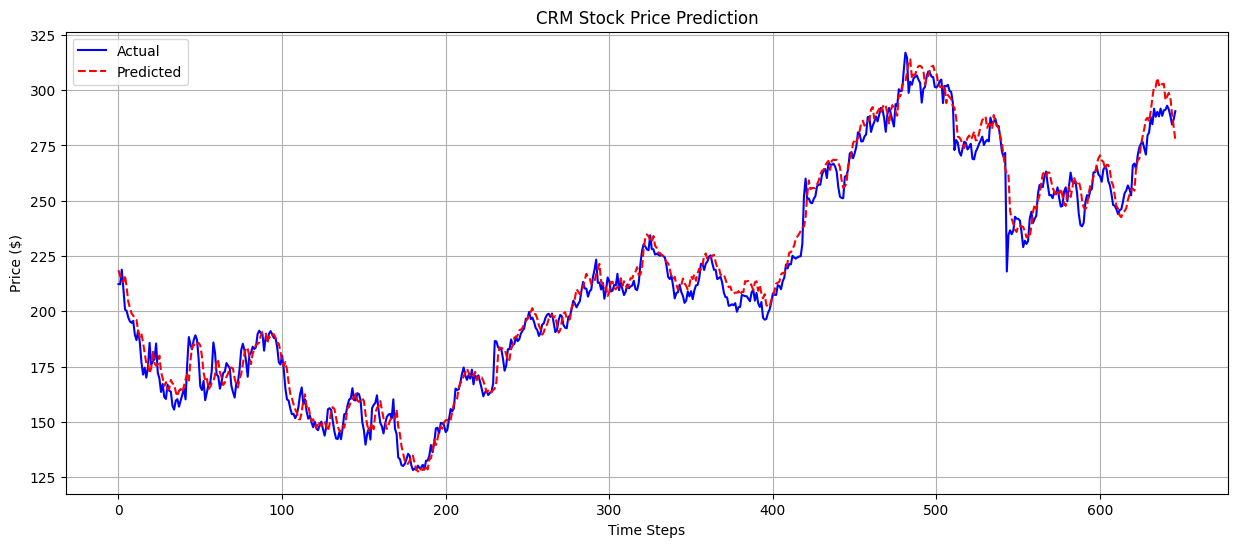


Analyzing JPM...

Evaluation Metrics for JPM:
MSE: 14.1530
RMSE: 3.7621
MAE: 2.9236


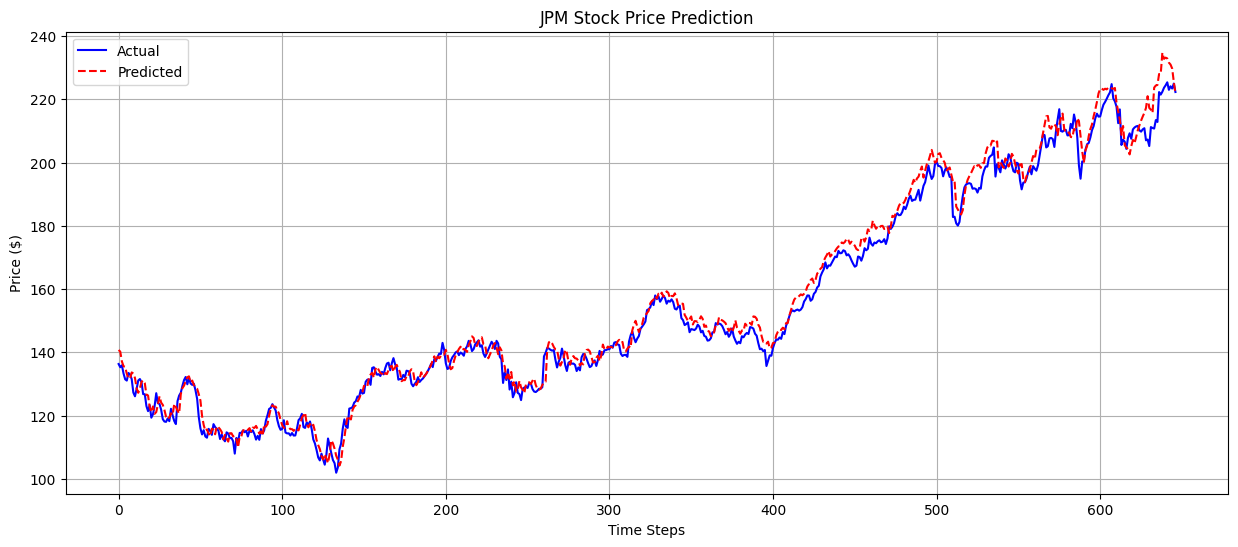


Analyzing V...

Evaluation Metrics for V:
MSE: 26.4405
RMSE: 5.1420
MAE: 4.1356


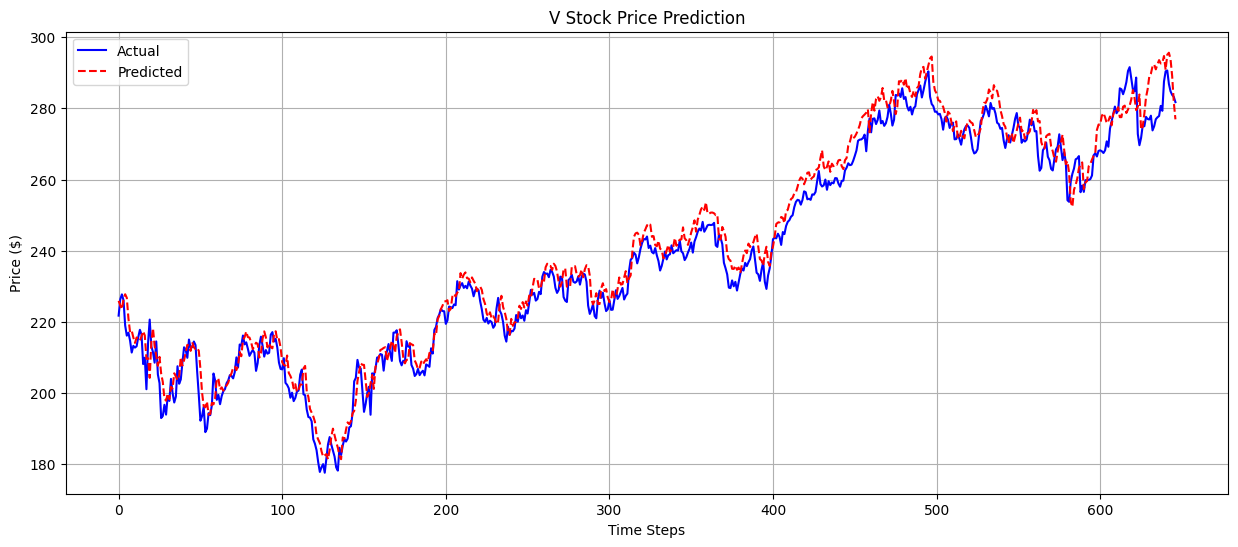


Analyzing MA...

Evaluation Metrics for MA:
MSE: 59.0348
RMSE: 7.6834
MAE: 5.7005


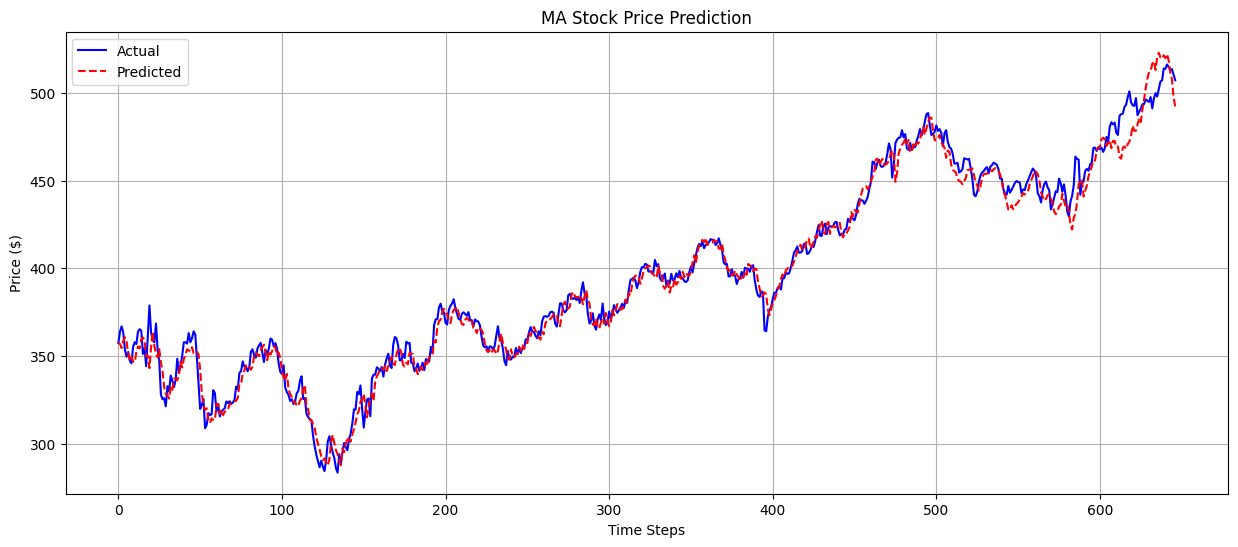


Analyzing MSTR...

Evaluation Metrics for MSTR:
MSE: 42.4293
RMSE: 6.5138
MAE: 4.1008


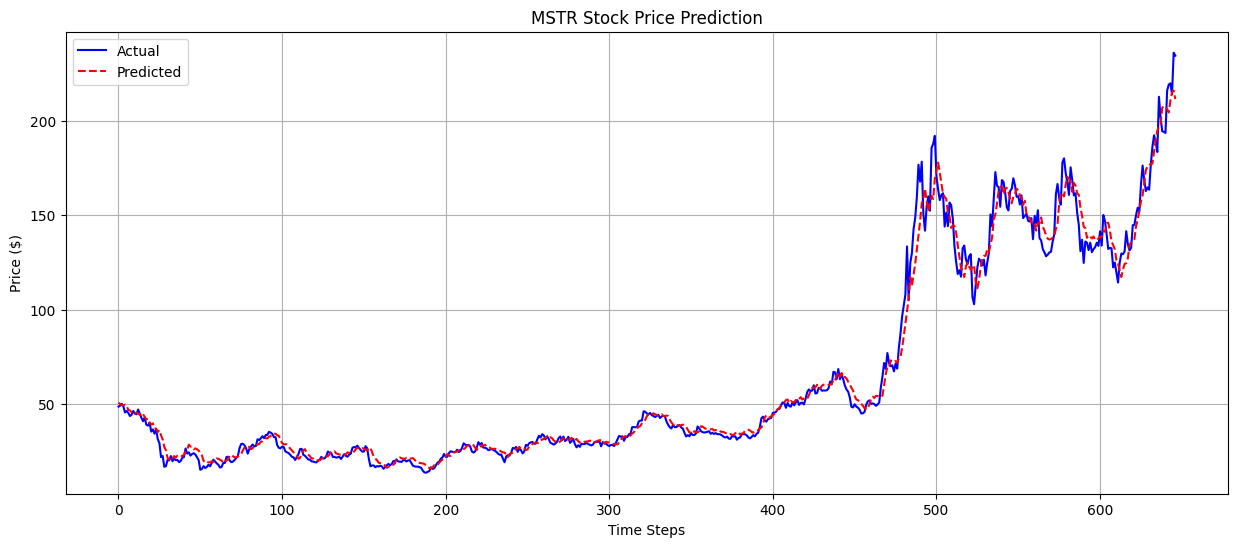


Analyzing DIS...

Evaluation Metrics for DIS:
MSE: 7.2053
RMSE: 2.6843
MAE: 2.0497


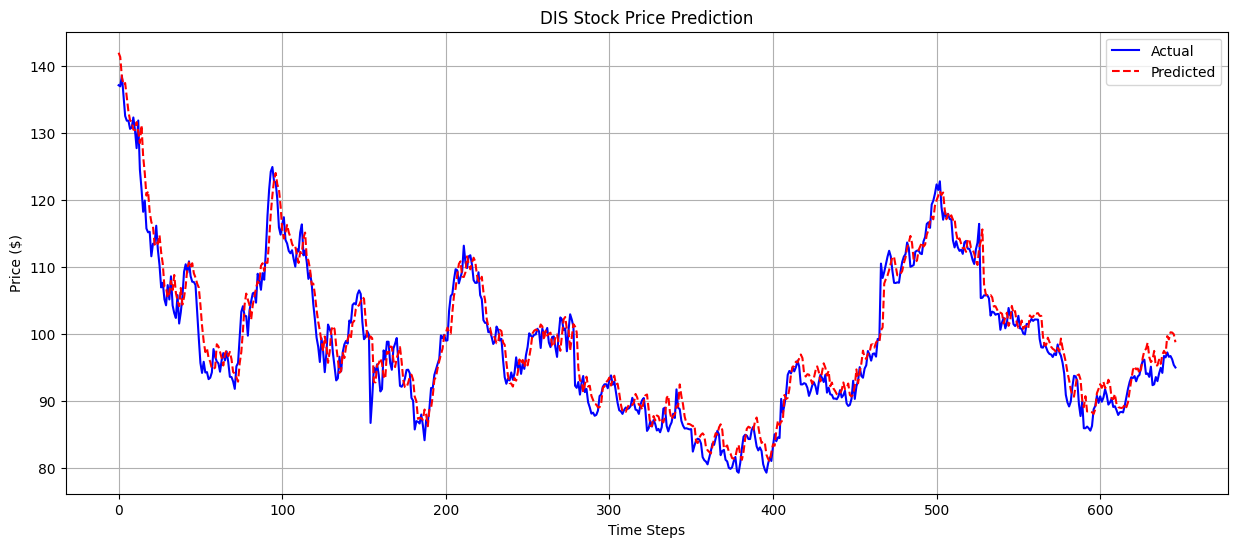


Analyzing BA...

Evaluation Metrics for BA:
MSE: 34.0698
RMSE: 5.8369
MAE: 4.5841


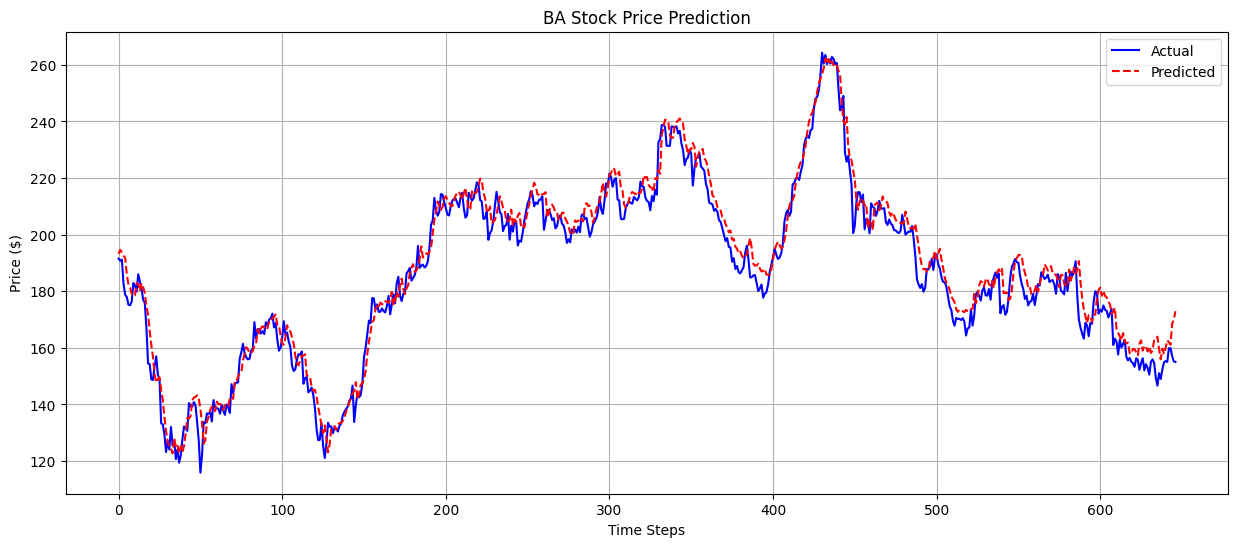


Analyzing XOM...

Evaluation Metrics for XOM:
MSE: 5.5546
RMSE: 2.3568
MAE: 1.8568


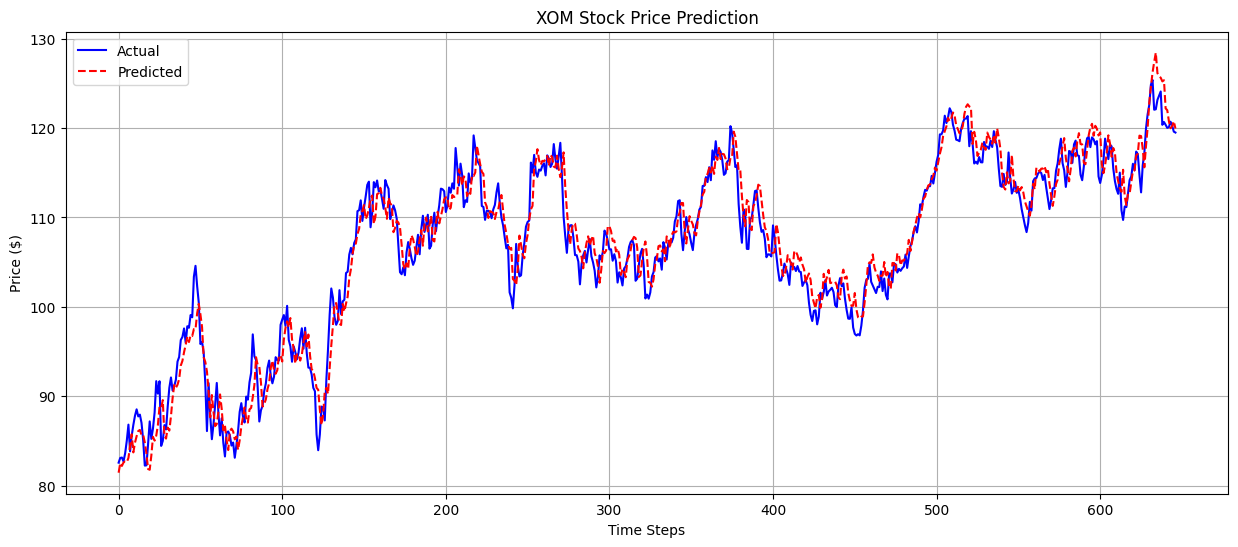


Analyzing ORCL...

Evaluation Metrics for ORCL:
MSE: 9.8395
RMSE: 3.1368
MAE: 2.2348


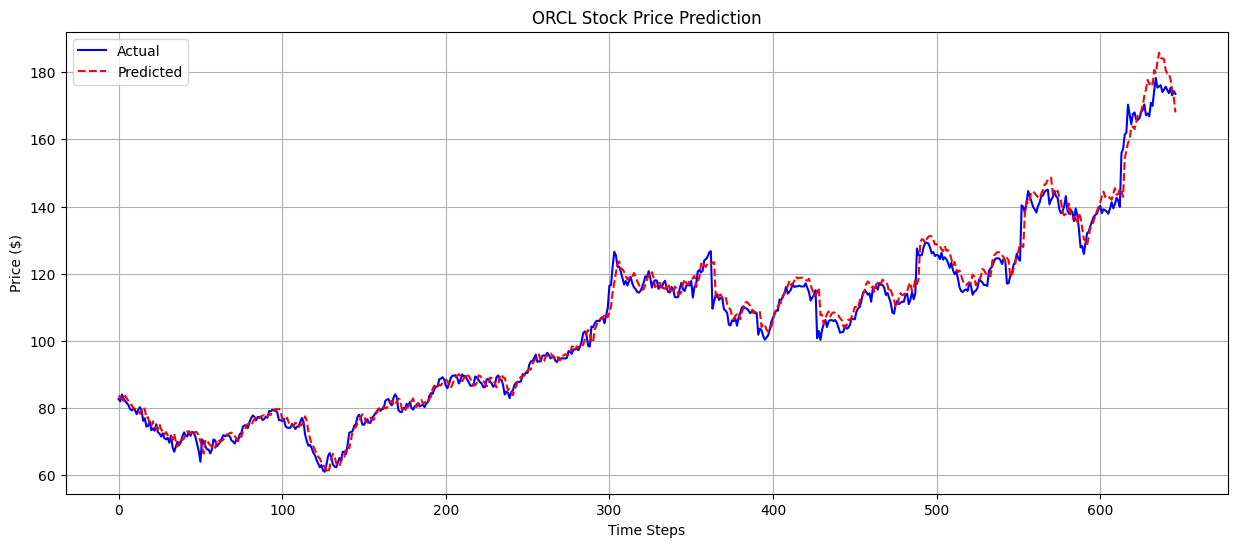


Analyzing META...

Evaluation Metrics for META:
MSE: 138.2365
RMSE: 11.7574
MAE: 8.1463


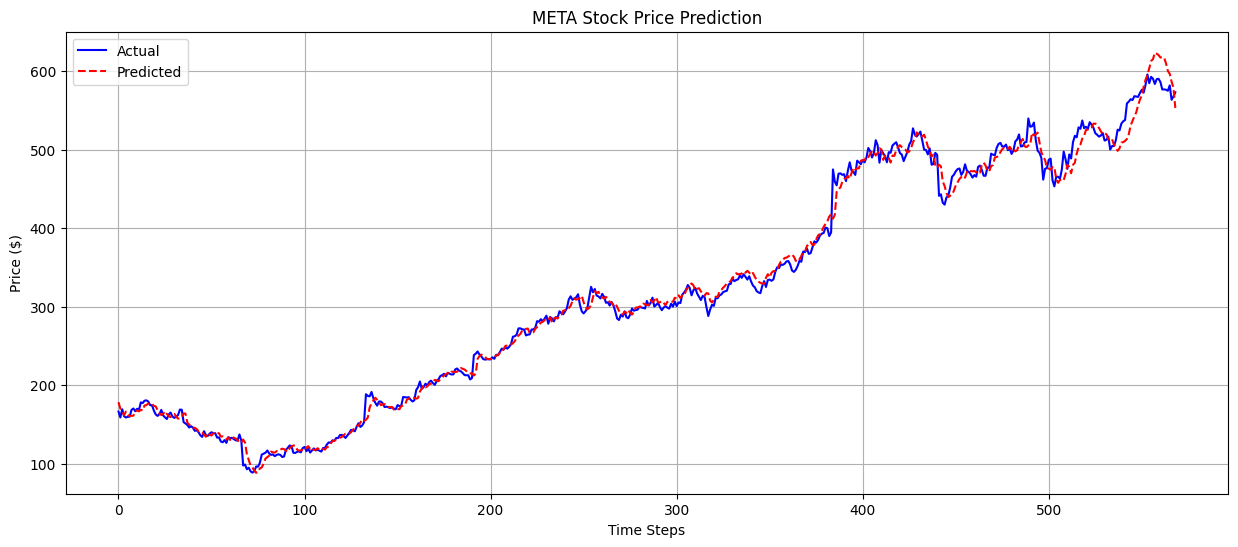


Analyzing BRK...

Evaluation Metrics for BRK:
MSE: 0.4994
RMSE: 0.7067
MAE: 0.4338


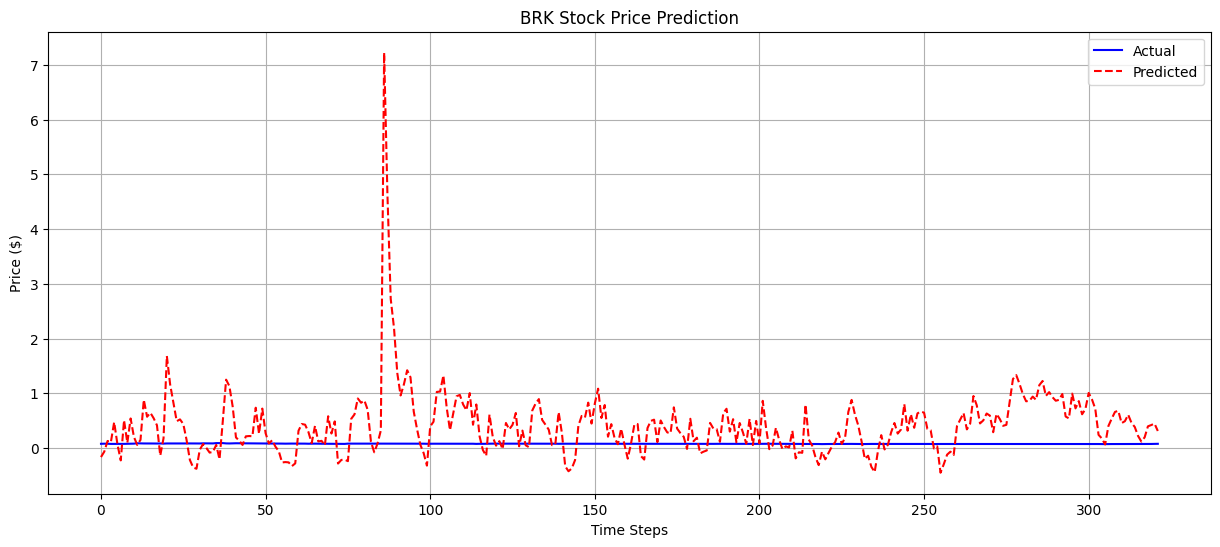


Analyzing HSBC...

Evaluation Metrics for HSBC:
MSE: 1.2259
RMSE: 1.1072
MAE: 0.8834


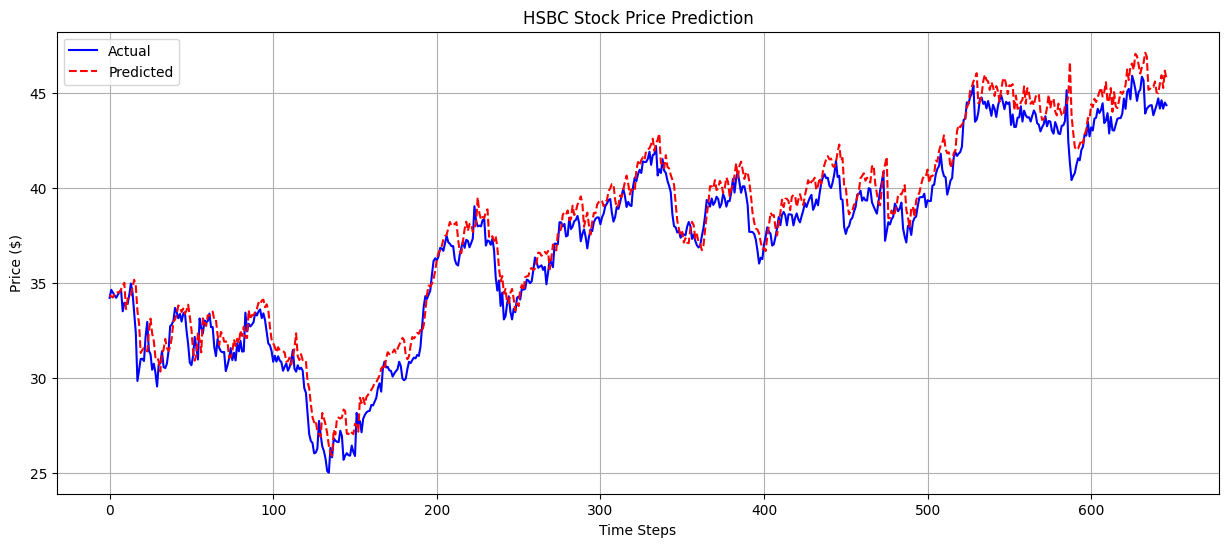


Analyzing MS...

Evaluation Metrics for MS:
MSE: 4.4368
RMSE: 2.1064
MAE: 1.6194


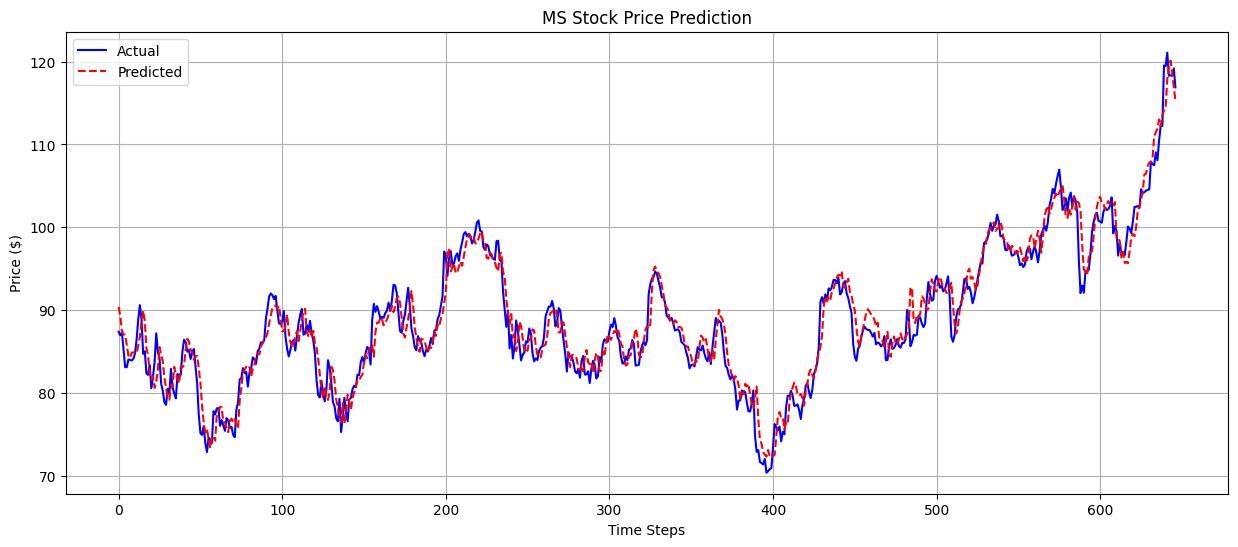


Analyzing PYPL...

Evaluation Metrics for PYPL:
MSE: 4.4035
RMSE: 2.0984
MAE: 1.5406


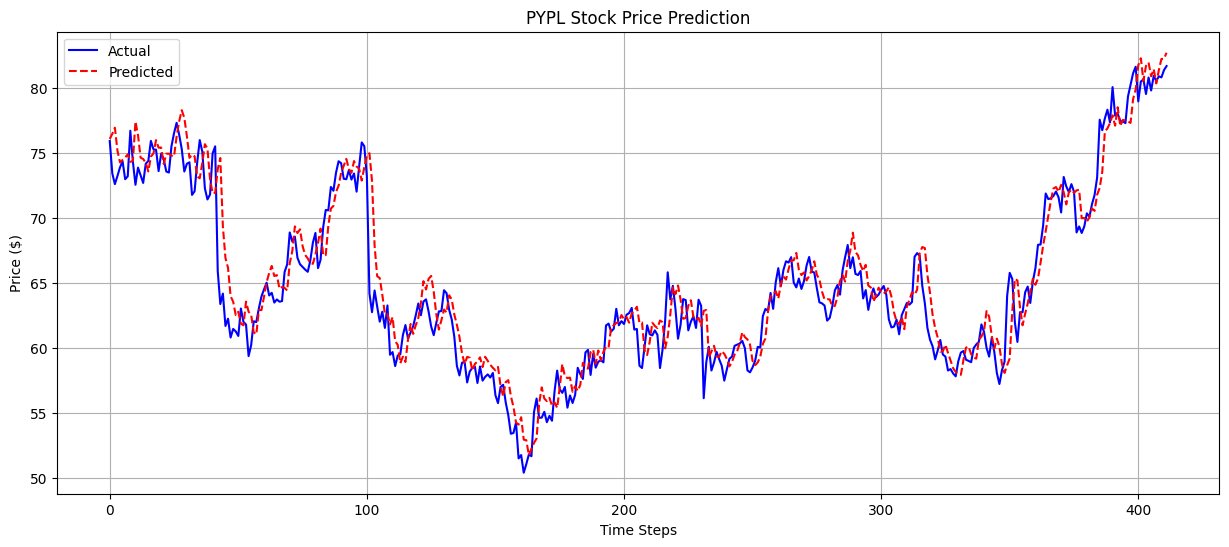


Analyzing BAC...

Evaluation Metrics for BAC:
MSE: 1.2208
RMSE: 1.1049
MAE: 0.9066


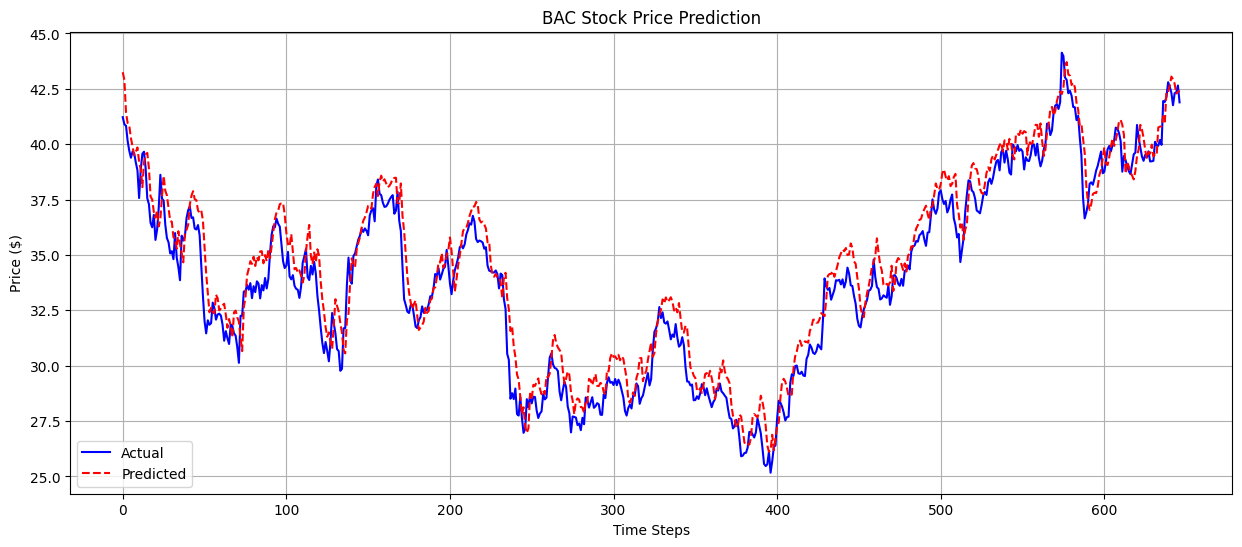


Analyzing BLK...

Evaluation Metrics for BLK:
MSE: 289.3686
RMSE: 17.0108
MAE: 12.4497


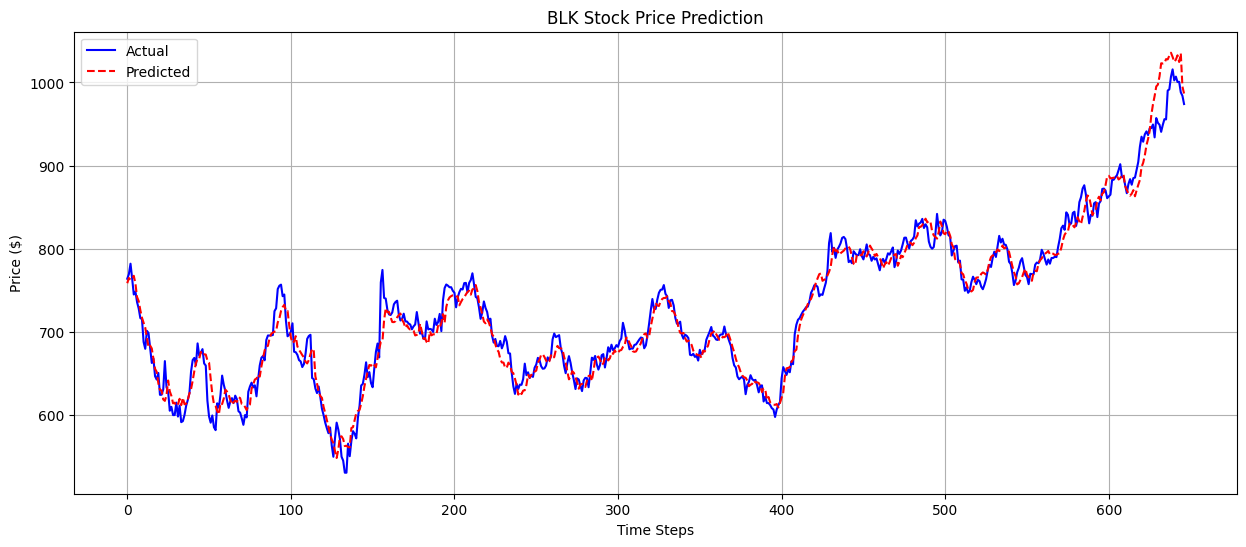


Analyzing GS...

Evaluation Metrics for GS:
MSE: 67.8442
RMSE: 8.2368
MAE: 6.3635


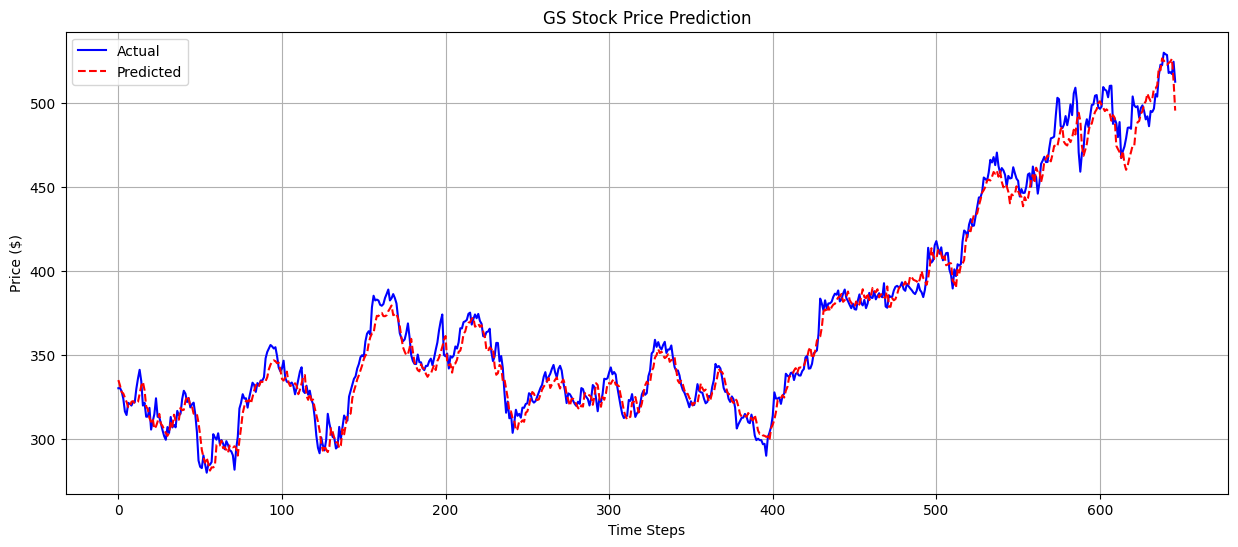


Summary of Metrics for All Stocks:
              MSE       RMSE        MAE
AAPL    24.179719   4.917288   3.875307
AMZN    21.550628   4.642265   3.607512
GME      6.982894   2.642517   1.698997
GOOGL   14.336856   3.786404   2.937030
NFLX   229.055530  15.134581  10.735139
TSLA   111.207820  10.545512   8.150845
MSFT    51.202346   7.155581   5.510664
NVDA     8.097781   2.845660   1.909381
AMD     24.498604   4.949606   3.795131
CRM     41.993333   6.480226   4.952768
JPM     14.153033   3.762052   2.923576
V       26.440506   5.142033   4.135602
MA      59.034801   7.683411   5.700531
MSTR    42.429298   6.513778   4.100803
DIS      7.205321   2.684273   2.049652
BA      34.069840   5.836938   4.584109
XOM      5.554627   2.356826   1.856799
ORCL     9.839526   3.136802   2.234815
META   138.236525  11.757403   8.146264
BRK      0.499427   0.706702   0.433754
HSBC     1.225925   1.107215   0.883416
MS       4.436766   2.106363   1.619383
PYPL     4.403487   2.098449   1.540603
BAC 

In [123]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 
           'BA', 'XOM', 'ORCL', 'META', 'BRK', 'HSBC', 'MS', 'PYPL', 'BAC', 'BLK', 'GS']

def split_validation_data(val_X, val_y, stock_lengths):
    """
    Split the combined validation data back into individual stocks.
    
    Args:
        val_X: Combined validation features
        val_y: Combined validation targets
        stock_lengths: List of number of validation samples for each stock
    """
    val_X_stocks = []
    val_y_stocks = []
    
    start_idx = 0
    for length in stock_lengths:
        val_X_stocks.append(val_X[start_idx:start_idx + length])
        val_y_stocks.append(val_y[start_idx:start_idx + length])
        start_idx += length
        
    return val_X_stocks, val_y_stocks

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day)
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate validation set lengths for each stock
def get_stock_val_lengths(values_list, train_split=0.8, n_steps_in=14, n_steps_out=5):
    """
    Calculate the number of validation samples for each stock
    """
    val_lengths = []
    for values in values_list:
        n_train = int(len(values) * train_split)
        val_data = values[n_train:]
        n_sequences = len(val_data) - n_steps_in - n_steps_out + 1
        if n_sequences > 0:
            val_lengths.append(n_sequences)
    return val_lengths

# Calculate validation lengths for each stock
val_lengths = get_stock_val_lengths(values_list)

# Split validation data back into individual stocks
val_X_stocks, val_y_stocks = split_validation_data(val_X, val_y, val_lengths)

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_stocks[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {
        'actual': val_y_stocks[i],
        'predicted': val_predictions
    }
    
    # Calculate metrics (using first day predictions)
    mse, rmse, mae = evaluate_predictions(
        val_y_stocks[i][:, 0],  # First day actual
        val_predictions[:, 0],   # First day predictions
        ticker,
        scaler
    )
    
    metrics_dict[ticker] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    
    # Plot predictions (first day)
    plot_predictions(
        val_y_stocks[i][:, 0],    # First day actual
        val_predictions[:, 0],     # First day predictions
        ticker,
        scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)